In [3]:
import funzioni01 as f1
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.ibmq.job import job_monitor
#from qiskit.providers.ibmq import least_busy
from copy import deepcopy
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.circuit import Parameter
import time
import qiskit.quantum_info as qi
from qiskit.utils import QuantumInstance
import qiskit.ignis.mitigation.measurement as mc
#from qiskit.result import marginal_counts
from sympy import *
import numpy as np
from sympy.solvers import solve
from sympy import Symbol
from sympy.physics.quantum import TensorProduct as Tp
from sympy import sqrt, cos, sin, acos, asin, atan
import numpy as np
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_sim_jakarta = sim_noisy_jakarta 
backend = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')


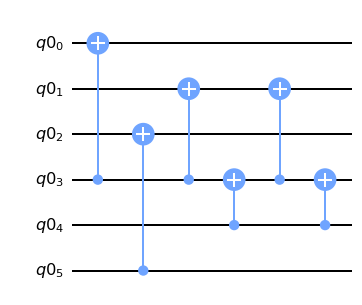

In [4]:
qr=QuantumRegister(6)
CheckC_qc=QuantumCircuit(qr,name ='CheckC')

CheckC_qc.cx(qr[3],qr[0])
CheckC_qc.cx(qr[5],qr[2])
CheckC_qc.cx(qr[3],qr[1])
CheckC_qc.cx(qr[4],qr[3])
CheckC_qc.cx(qr[3],qr[1])
CheckC_qc.cx(qr[4],qr[3])

CheckC_qc.draw(output="mpl")

In [5]:
res=[]
qubits=[0,2,4,1,3,5]
shots=32000

for i in range(6):

    mat=np.zeros([2,2])

    for j in range(2):

        cr=ClassicalRegister(1)
        qr=QuantumRegister(7)
        qc=QuantumCircuit(qr,cr)

        #qc.reset(qr[qubits[i]])

        if j==1:
            qc.x(qr[qubits[i]])
        
        qc.measure(qr[qubits[i]],cr)

        job=execute(qc, backend=backend_sim_jakarta, shots=shots)

        aus = job.result().get_counts()
        
        if '0' in aus:
            mat[0][j]=aus['0']/shots
        
        if '1' in aus:
            mat[1][j]=aus['1']/shots
    
    res.append(Matrix(mat))

single_qubits = res[0]
for i in range(1,6):
    single_qubits=Tp(single_qubits,res[i])


In [6]:
meas_fitter=f1.calibration_measure_mitigation(qubit=[0,2,4,1,3,5],backend_calibration=backend_sim_jakarta, shots=shots)

Procedura di calibrazione in corso!
Calibrazione completata!


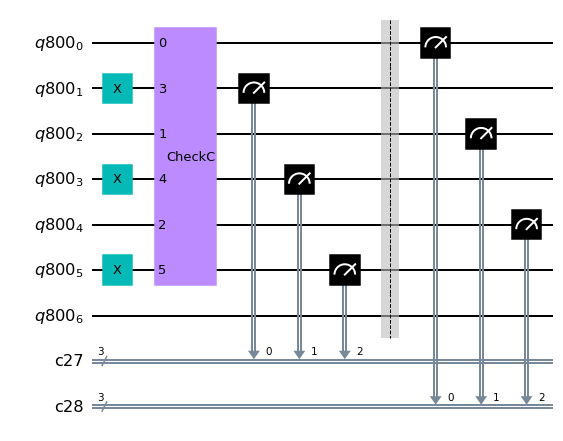

In [7]:


qubits=[1,3,5]
pos_init=f1.bin_list(3)
mat=np.zeros([2**3,2**3])
qcs=[]

for i in range(2**3):

    crq=ClassicalRegister(3)
    cra=ClassicalRegister(3)
    qr=QuantumRegister(7)
    qc=QuantumCircuit(qr,crq,cra)

    l=0
    for k in [5,3,1]:
        if pos_init[i][l]=='1':
            qc.x(qr[k])
        l+=1

    qc.append(CheckC_qc,[qr[0],qr[2],qr[4],qr[1],qr[3],qr[5]])

    qc.measure([qr[1],qr[3],qr[5]],crq)
    qc.barrier()
    qc.measure([qr[0],qr[2],qr[4]],cra)

    qcs.append(qc)

qcs[-1].draw(output="mpl")


In [8]:

job=execute(qcs, backend=backend_sim_jakarta, shots=shots)


In [9]:
raw_results=job.result()

N_ancillas=3
N_qubit=6
new_result = deepcopy(raw_results)
new_result_nm = deepcopy(raw_results)

matrix_check=np.zeros([2**3,2**3])
matrix_check_nm=np.zeros([2**3,2**3])

################create the list of the total possible outcomes
r=f1.bin_list(N_qubit=N_qubit)
r_split=[]

for j in range(2**(N_qubit)):
    X_aus=''
    X_aus+=r[j][:N_ancillas]
    X_aus+=' '
    X_aus+=r[j][N_ancillas:]
    r_split.append(X_aus)

for i in range(len(raw_results.results)): 
    
    old_counts = raw_results.get_counts(i)
    new_counts = {}
    new_counts_nm = {}

    new_result.results[i].header.creg_sizes = [new_result.results[i].header.creg_sizes[0]]
    new_result.results[i].header.clbit_labels = new_result.results[i].header.clbit_labels[0:-1]
    new_result.results[i].header.memory_slots = 3

    new_result_nm.results[i].header.creg_sizes = [new_result_nm.results[i].header.creg_sizes[0]]
    new_result_nm.results[i].header.clbit_labels = new_result_nm.results[i].header.clbit_labels[0:-1]
    new_result_nm.results[i].header.memory_slots = 3

    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        if reg_bits[0] == reg_bits[1]:
            new_counts_nm[reg_bits[1]]=old_counts[reg_key]


    new_result_nm.results[i].data.counts = new_counts_nm

    for j in range(2**N_qubit):
        if r_split[j] in old_counts.keys():
            old_counts[r[j]] = old_counts.pop(r_split[j])
    
    old_counts = meas_fitter.filter.apply(old_counts, method='least_squares')

    for j in range(2**N_qubit):
        if r[j] in old_counts.keys():
            old_counts[r_split[j]] = old_counts.pop(r[j])

    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        if reg_bits[0] in reg_bits[1]:
            new_counts[reg_bits[1]]=old_counts[reg_key]

    new_result.results[i].data.counts = new_counts

for i in range(len(raw_results.results)):

    norm=sum(new_result_nm.get_counts(i).values())
    print(norm)

    l=0
    for k in pos_init:
        if k in new_result_nm.get_counts(i):
            matrix_check_nm[l][i]=new_result_nm.get_counts(i)[k]/norm
        l+=1

    norm=sum(new_result.get_counts(i).values())
    print(norm)

    l=0
    for k in pos_init:
        if k in new_result.get_counts(i):
            matrix_check[l][i]=new_result.get_counts(i)[k]/norm
        l+=1

28194
31217.022722552018
24766
30116.720551156377
26483
30865.254567149197
23510
29995.155516838866
26916
31114.19420179127
23739
29906.816298799138
25558
31068.539699790323
22706
30003.97004864384


In [10]:
Matrix(matrix_check_nm)

Matrix([
[   0.996027523586579, 0.00932730356133409, 0.00222784427746101, 0.00012760527435134,  0.00456977262594739,                    0,                    0,                   0],
[ 0.00120593033978861,   0.988250020188969, 3.77600724993392e-5,  0.0024670353041259,                    0,  0.00433885167867223,                    0,                   0],
[0.000177342697027736,                   0,   0.993429747385115,  0.0102509570395576,                    0,                    0,  0.00469520306753267,                   0],
[                   0, 8.07558749899055e-5, 0.00139712268247555,   0.984134410888983,                    0,                    0,                    0, 0.00453624592618691],
[ 0.00258920337660495,                   0,                   0,                   0,     0.99398127507802,  0.00947807405535195,  0.00223022145707802, 8.80824451686779e-5],
[                   0, 0.00234192037470726,                   0,                   0,  0.00122603655818101,      0.985930

In [11]:
Matrix(matrix_check)

Matrix([
[   0.999999999997868,                    0, 1.36614804606388e-12, 2.07685828729469e-12, 2.45561463238407e-12, 3.86704816529518e-13, 2.52072293012148e-14,                    0],
[                   0,    0.999999999999997, 1.74756730689144e-14, 7.05022329157696e-12, 5.12326018903959e-15, 5.32503790537321e-12, 2.52091618027782e-14,                    0],
[                   0, 1.74113221044716e-16,    0.999999999996908, 1.60518223719347e-15,                    0, 3.65087846141431e-13, 0.000116215496668727,                    0],
[4.04039854352392e-13, 3.81711156590857e-16, 2.46337669798799e-15,    0.999999999971746,                    0, 3.77183982901781e-13, 6.42803419257418e-15,                    0],
[1.24302012913695e-13,  1.8475241959111e-16, 7.50231928019081e-16, 1.32984696827822e-12,    0.999999999997424,                    0, 8.72203038460872e-14, 4.00558766486159e-13],
[6.99054786624487e-13, 1.84818785686913e-15, 8.01241176037402e-16, 1.38592359712812e-12,             

In [12]:
meas_fitter.cal_matrix=matrix_check_nm0

NameError: name 'matrix_check_nm0' is not defined

In [30]:
qr_q=[1,3,5]
qr_anc=[0,2,4]

qr=qr_q+qr_anc
qr

[1, 3, 5, 0, 2, 4]